### Introduction to Data Science (Computer Assignment number one)

### Professors: Bahrak and Yaghoob Zade

### Students: Mohamad Mahdi Samadi (810101465) and Kasra Ghorbani Aghil Abadi (810101489)

## Hypothesis Testing
First let's see what it is. Hypothesis testing is a statistical method used to make decisions based on sample data. There are two hypotheses: the null hypothesis (H0), which is the assumption that there's no effect, and the alternative hypothesis (H1), which is against H0 and claims that there is a difference. We have to choose a significance level (here we set it on 0.05 which is usualy used in hypothesis tests), which is the probability of rejecting H0 when it is true. p-value is the probability of observing the test statistic or a more extreme value, assuming the null hypothesis is true. Last step is to make the desicion whether H0 is true or not. If the p-value is less than alpha, reject H0. If the p-value is greater than alpha, fail to reject H0.

### Imports and defines

In [1669]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

p = 0.55
null_hypothesis_coin_test = 0.5
significance_level = 0.05

## Unfair Coin

This function is really simple. it simulates flipping a coin with the given probability of landing heads (1). It repeats the flipping 'sample_size' times.

In [1670]:
def flip_coin(sample_size, p):
    return [1 if random.uniform(0, 1) <= p else 0 for _ in range(sample_size)]


In cases like this where the variance isn't known, We have to estimate it in a unbiased way.

In [1671]:
def estimate_variance(sample):
    X_bar = np.mean(sample)
    S_squared = 0
    for Xi in sample:
        S_squared += np.power((Xi - X_bar), 2)
    return S_squared / (len(sample)-1)

Two methods of hypothesis testing.

In [1672]:
def test_by_confidence_interval(mu, S, n):
    std_err = S / np.sqrt(n)
    margin_err = 1.96 * std_err
    confidence_interval = [mu - margin_err, mu + margin_err]
    return confidence_interval    

def test_by_pvalue(mu, S, n):
    std_err = S / np.sqrt(n)
    z_score = (mu - null_hypothesis_coin_test) / std_err
    p_value = 2 * stats.norm.sf(abs(z_score))
    return p_value

Just a simple function to run the test on different sample sizes.

In [1673]:
def test_coin(sample_sizes):
    result = []
    for sample_size in sample_sizes:
        sample = flip_coin(sample_size=sample_size, p=p)
        X_bar = np.mean(sample)
        S = np.sqrt(estimate_variance(sample))
        confidence_interval = test_by_confidence_interval(mu=X_bar, S=S, n=sample_size)
        pvalue = test_by_pvalue(mu=X_bar, S=S, n=sample_size)
        result.append([pvalue, pvalue > significance_level, confidence_interval
                       , null_hypothesis_coin_test > confidence_interval[0] and null_hypothesis_coin_test < confidence_interval[1]])    
    return result

def show_result_coin_test(result):
    df = pd.DataFrame(result)
    df.columns = ["p-value", "accepted by p-value test"
                  ,"confidence interval", "is in confidence interval"]
    df["confidence interval"] = df["confidence interval"].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
    df["accepted by p-value test"] = df["accepted by p-value test"].apply(lambda x: "Fail to reject H0" if x else "Reject H0")
    df["is in confidence interval"] = df["is in confidence interval"].apply(lambda x: "Fail to reject H0" if x else "Reject H0")
    return df

sample_sizes = [30, 100, 1000, 100000]
result = test_coin(sample_sizes=sample_sizes)
show_result_coin_test(result=result)

,p-value,accepted by p-value test,confidence interval,is in confidence interval
0,2.716625e-01,Fail to reject H0,"(0.422, 0.778)",Fail to reject H0
1,4.225402e-02,Reject H0,"(0.503, 0.697)",Reject H0
2,1.921026e-05,Reject H0,"(0.536, 0.598)",Reject H0
3,7.508907e-216,Reject H0,"(0.546, 0.552)",Reject H0


## Job Placement

Defined variables used in this part. 

In [1674]:
null_hypothesis_job_placement = 0 
significance_level = 0.05
file_path = "./job_placement.csv"

Reading data

In [1675]:
def read_file(file_path):
    return pd.read_csv(file_path)

This function splits students into two groups based on their job placement. As you know all we need is the 'gpa' column of the dataframe.

In [1676]:
def separate_needed_data(df):
    sample1 = df[df["placement_status"] == "Placed"]["gpa"]
    sample2 = df[df["placement_status"] == "Not Placed"]["gpa"]
    return sample1, sample2

A simple and not necessarily correct way to check if working alongside studying does or does not effect gpa is to compare the mean of two groups. It seems that working is a good thing while students are still studying.

In [1677]:
sample1, sample2 = separate_needed_data(df=read_file(file_path=file_path))
df = pd.DataFrame(columns=["mean GPA"])
df["mean GPA"] = {"Placed": np.mean(sample1), "Not placed": np.mean(sample2)}
df

,mean GPA
Placed,3.761404
Not placed,3.702308


To be more precise, Here is the boxplot of two groups. As you can see the three quantiles of two groups are about the same.

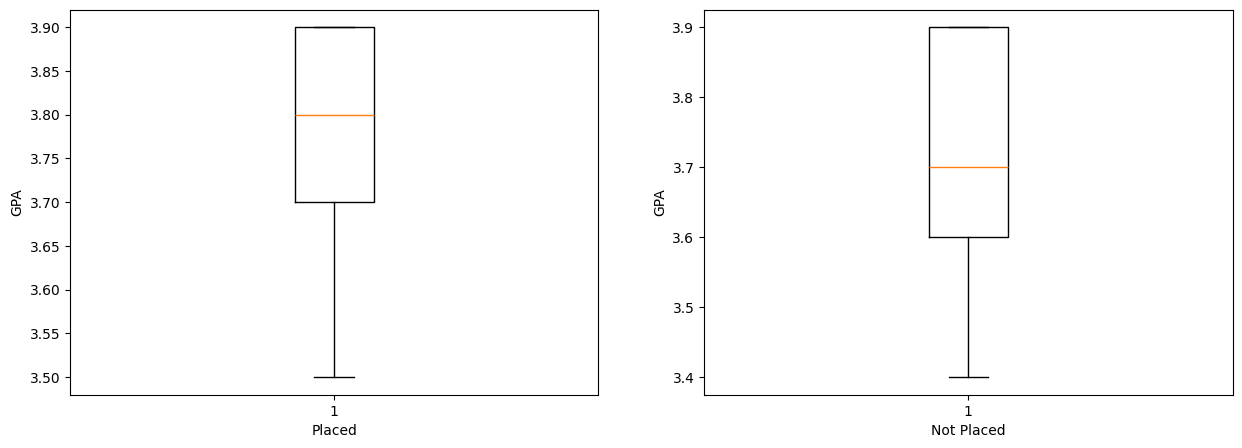

In [1678]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.boxplot(sample1)
ax0.set_xlabel('Placed')
ax0.set_ylabel('GPA')
ax1.boxplot(sample2)
ax1.set_xlabel('Not Placed')
ax1.set_ylabel('GPA')
plt.show()

$$df = \sum_{i=1}^{n} {(N_i - 1)}

In [1679]:
def calc_degres_of_freedom(sample1, sample2):
    return (len(sample1) - 1) + (len(sample2) - 1)

### Separate variances:
$$t-statistic = \frac{\bar{X_1} - \bar{X_2} - H_0} {\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}$$

### Equal variances:
$$t-statistic = \frac{\bar{X_1} - \bar{X_2} - H_0} {\sqrt{\frac{{{S_1^2}\times{(n_1-1)} + {S_2^2}\times{(n_2-1)}}}{n_1+n_2-2} \times (\frac{1}{n_1} + \frac{1}{n_2})}}$$

In [1680]:
def calc_t_statistic(sample1, sample2, equal_var=False):
    X_bar1 = np.mean(sample1)
    X_bar2 = np.mean(sample2)
    n1, n2 = len(sample1), len(sample2)
    if equal_var:
        var1, var2 = estimate_variance(sample1), estimate_variance(sample2)
        pooled_variance = ((n1-1) * var1 + (n2-1) * var2) / (n1+n2-2)
        std_err = np.sqrt(pooled_variance * (1/n1 + 1/n2))        
    else:
        std_err = np.sqrt(np.var(sample1)/n1 + np.var(sample2)/n2)
    return abs(X_bar1 - X_bar2 - null_hypothesis_job_placement) / std_err


Now that the nedded parameters are ready we can calculate p-value.

In [1681]:
def calc_p_value(df, t_statistic):
    return stats.t.cdf(t_statistic, df)

In [1682]:
def judge_hypothesize(p_value, significance_level):
    return p_value < significance_level

This function tests the sample four times. First time using scipy library and another time by the hand calculated parameters. And for each of them once assuming equal variances for both groups and then assuming that each group has its own variance.

In [1683]:
def perform_t_test(sample1, sample2):
    degree_of_freedom = calc_degres_of_freedom(sample1=sample1, sample2=sample2)
    t_statistic, p_value, res = [[None] * 4 for _ in range(3)]

    for i in range(2):
        t_statistic[i] = calc_t_statistic(sample1=sample1, sample2=sample2, equal_var=bool(i))
        p_value[i] = calc_p_value(df=degree_of_freedom, t_statistic=t_statistic[i])
        t_statistic[i+2], p_value[i+2] = stats.ttest_ind(sample1, sample2, alternative = "less", equal_var=bool(i))

    res[i] = (judge_hypothesize(p_value=p_value[i], significance_level=significance_level) for i in range(4))

    result = [{"t-statistic": t_statistic[i], "p-value": p_value[i], "accepted by t-test": res[i]} for i in range(4)]
    return result

def show_result_job_test(result):
    df = pd.DataFrame(result, index=["separate vars", "equal vars", "scipy separate", "scipy equal"])
    df["accepted by t-test"] = df["accepted by t-test"].apply(lambda x: "Fail to reject H0" if x else "Reject H0")
    return df

Running the functions.

In [1684]:
df = read_file(file_path=file_path)
sample1, sample2 = separate_needed_data(df=df)
result = perform_t_test(sample1=sample1, sample2=sample2)
show_result_job_test(result=result)

,t-statistic,p-value,accepted by t-test
separate vars,4.458121,0.999995,Reject H0
equal vars,5.105319,1.000000,Fail to reject H0
scipy separate,4.442633,0.999992,Reject H0
scipy equal,5.105319,1.000000,Reject H0


As i mentioned, The t-test was performed twice based on the variance situation. The t-tests revealed that there was a small difference in the t-statistic depending on the assumption of equal or unequal variances. However, this difference did not affect the overall conclusion, as both tests showed that there was no harm in working alongside studying. 

## Questions
Let's answer some qustions.

### How does increasing the sample size affect your coin test?

Sample size plays an important role in statistical tests, including hypothesis testing. With a larger sample size, the test is more likely to detect a true effect, even small ones. The coin test with a larger sample size is more likely to detect the unfairness and reject the null hypothesis that the coin is fair. Also with a larger sample size, the estimate of the true probability of getting heads (or tails) becomes more precise. This is because the standard deviation of the sample decreases as the sample size increases and leads to a smaller confidence interval for the true value. In this problem as a result of increasing the sample size, z-score and p-value whould have extremly small values. It means that the larger the sample is, The more accurate the observation gets and we would decisively reject hypothesises.

### What are t-statistic, degrees of freedom, and t-distribution in t-test? How can they help us to compare two data sets?
*t-statistic*: The t-statistic is a measure of the difference between two sample means based on the variability within the samples. It is used in t-test to decide whether there is a significant difference between the two sample means or not.

*Degrees of freedom*: Degrees of freedom (mentioned as 'df' in the code) is the only parameter used in statistical tests that determines the shape of the t-distribution. In our test, the degrees of freedom is calculated as the total number of observations in both samples minus 2. But in fact it's sum of all group sizes minus number of groups. In smaller degrees of freedom, the t-distribution behaves much more cautious than the normal distribution. For example, at lower degrees of freedom, this distribution skews slowly towards zero and still has a significant value at a distance of 3 sigma from the mean.

*t-distribution*: The t-distribution is a probability distribution. The shape of the t-distribution depends on the degrees of freedom. But both the t-distribution and the standard normal distribution are symmetric, bell-shaped distributions. They have a single peak at their mean (which is 0). Despite these similarities, the t-distribution and the normal distribution have some differences. the t-distribution has heavier tails (higher kurtosis) compared to the normal distribution, especially when the degrees of freedom are low. This means that extreme values are more likely in the t-distribution than in the normal distribution. As the degrees of freedom increase, the t-distribution becomes more similar to the normal distribution.

### What are the preliminary conditions for using t-test on our data?
Before using a t-test to analyze our data, we should be sure that the data meets certain assumptions or preliminary conditions. These conditions help to be sure that the results of the t-test are valid. Here are some assumptions for using a t-test:

The observations within each sample should be independent of one another. This means that the value of one observation should not influence the value of another observation. Also inside each sample we need to have randomness and independency. One of the conditions to reach independency is that the sample must be less than 10 percent of the whole population. Another one is that if there is skewness in the population we have to choose larger sample to deactive the effect of that.

Another important assumption is that the variances of the two populations are equal (or at least are really close). If this assumption is violated, we may need to use another test, such as Welch's t-test, which does not assume equal variances.

Unlike the z-test we can work with sample sizes less than 30 too. In fact the df gives us more power to work with samples.

### Read about some other types of tests that are used in scientific research. Write a line about each of them.
There are several other statistical tests commonly used in scientific research, each with its specific purpose and assumptions.

Analysis of Variance (ANOVA): ANOVA is used to compare the means of three or more groups to determine if they are significantly different from each other. It's a generalized form of t-test.

The Kruskal-Wallis H test is a non-parametric alternative to one-way ANOVA, used to compare three or more independent groups when the dependent variable is ordinal or does not meet the normality assumption.

Correlation analysis measures the strength and direction of the relationship between two continuous variables. Pearson's correlation is used when both variables are normally distributed, while Spearman's correlation is used when at least one variable is not normally distributed.

The Mann-Whitney U test is a non-parametric alternative to the independent samples t-test, used to compare two independent groups when the dependent variable is ordinal or does not meet the normality assumption.

The Kolmogorov-Smirnov (KS) test is a non-parametric statistical test used to compare two samples or a sample and a reference probability distribution. It measures the largest absolute difference between the CDFs of them. This test is useful for testing the goodness-of-fit and determining if two samples come from the same distribution.